<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Chicago West Nile Virus Prediction

### Contents:
#### Part 3 (of 4)
- Executive Summary
- Problem Statement
- Background & Research
- Data Wrangling
- Exploration & Visualisation
- [Pre-Processing & Modelling](#Pre-Processing-&-Modelling)
- [Results & Analysis](#Results-&-Analysis)
- [Kaggle Prediction](#Kaggle-Prediction)
- Cost-Benefit Analysis
- Recommendations
- Conclusions
- References

## Pre-Processing & Modelling

### Import Libraries

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score

%matplotlib inline 

### Pre-Processing of Trap-Weather Dataset

#### Import Trap-Weather Dataset

In [2]:
# import trap-weather dataset and save as trap_weather dataframe
trap_weather = pd.read_csv('../data/train_weather_clean.csv')

In [3]:
# show first 5 rows of dataset
trap_weather.head()

,Date,Day,Month,Year,Species,Trap,Latitude,Longitude,Station,NumMosquitos,...,RH,DewPoint,WetBulb,Heat,Cool,PrecipTotal,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,29,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,2,1,...,50.000000,59.0,66.0,0.0,12.0,0.0,30.09,5.8,16.0,7.4
1,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,1,...,55.555556,58.0,65.0,0.0,9.0,0.0,30.11,5.8,18.0,6.5
2,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,1,...,55.555556,58.0,65.0,0.0,9.0,0.0,30.11,5.8,18.0,6.5
3,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,2,1,...,50.000000,59.0,66.0,0.0,12.0,0.0,30.09,5.8,16.0,7.4
4,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,1,...,55.555556,58.0,65.0,0.0,9.0,0.0,30.11,5.8,18.0,6.5


#### Correlation of Weather Features and Presence of WNV


In [4]:
# view columns in trap weather dataset
trap_weather.columns

Index(['Date', 'Day', 'Month', 'Year', 'Species', 'Trap', 'Latitude',
       'Longitude', 'Station', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin',
       'Tavg', 'RH', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

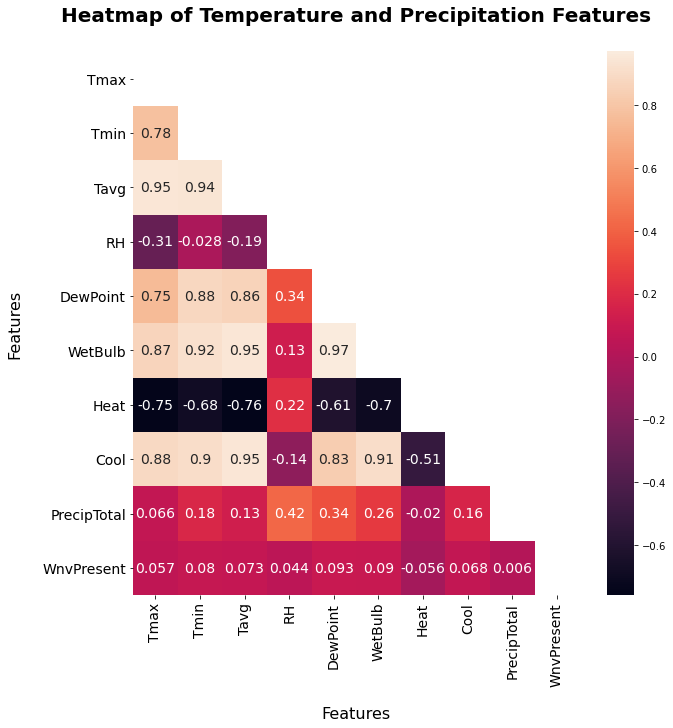

In [5]:
#create heatmap for temperature and precipitation features

#create plot
plt.figure(figsize=(10,10))

#create correlation matrix 
wnv_temp = trap_weather[[
    'Tmax', 'Tmin', 'Tavg',
     'RH', 'DewPoint', 'WetBulb',
    'Heat', 'Cool', 'PrecipTotal',
    'WnvPresent'
]]
corrMatrix = wnv_temp.corr()

#create triangle mask
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

#plot heatmap
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size":14}, mask = mask)

#set title and x,y labels
plt.title("Heatmap of Temperature and Precipitation Features", pad=30, weight='bold', size=20)

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set labels
plt.xlabel('Features', labelpad=20, size=16)
plt.ylabel('Features', labelpad=20, size=16)

plt.savefig('../plots/heatmap-temp-precip.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deductions**:
- In the above heatmap, it can be seen that 'Tavg', 'Tmax' and 'Tmin' have a strong correlation with each other. To reduce multicollinearity, we will keep 'Tavg' and drop 'Tmax' and 'Tmin' to represent the temperature variable. 
- Since relative humidity ('RH') is a function of 'Tavg' and 'Dewpoint', we can drop 'Dewpoint' and use 'RH' to represent the humidity variable.   
- Since 'Wetbulb', 'Heat' and 'Cool' show a strong correlation with 'Tavg', we can drop those columns and keep 'Tavg' to represent the temperature variable.  
- 'PrecipTotal' shows a low positive correlation to 'RH' and negligible correlation to the other features so we can keep it.
- Hence, we will only keep 'Tavg', 'RH' and 'PrecipTotal' columns in our dataset.

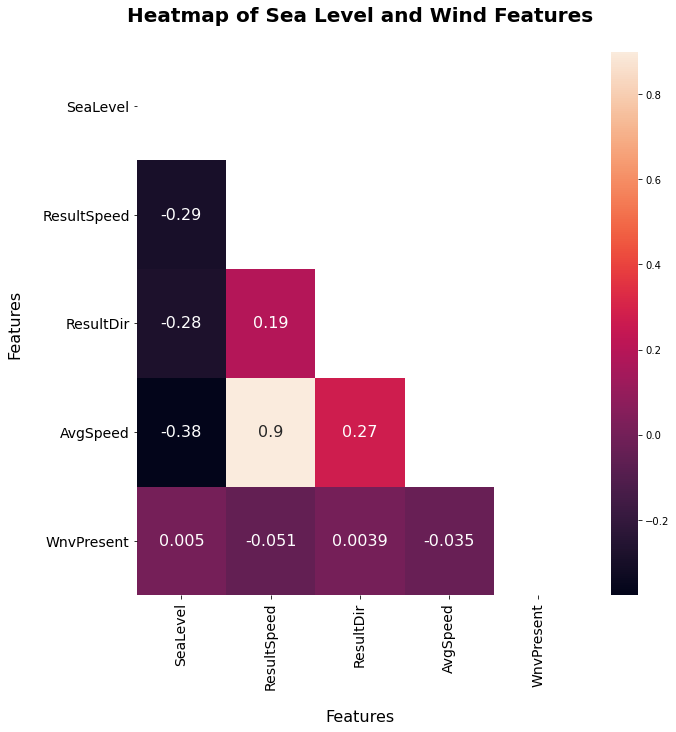

In [6]:
#create heatmap for sea level and wind features
#create plot
plt.figure(figsize=(10,10))

#create correlation matrix 
wnv_wind = trap_weather[[
    'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'WnvPresent'
]]
corrMatrix = wnv_wind.corr()

#create triangle mask
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

#plot heatmap
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size":16}, mask = mask)

#set title and x,y labels
plt.title("Heatmap of Sea Level and Wind Features", pad=30, weight='bold', size=20)

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14, rotation = 90)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set labels
plt.xlabel('Features', labelpad=20, size=16)
plt.ylabel('Features', labelpad=20, size=16)

plt.savefig('../plots/heatmap-sea-wind.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: From the above heatmap, we can see that 'AvgSpeed' and 'ResultSpeed' show a strong correlation with each other. Hence, we will keep 'AvgSpeed' and drop 'ResultSpeed' to represent the wind speed, as 'AvgSpeed' is more interpretable. The rest of the features do not show significant multicollinearity. 

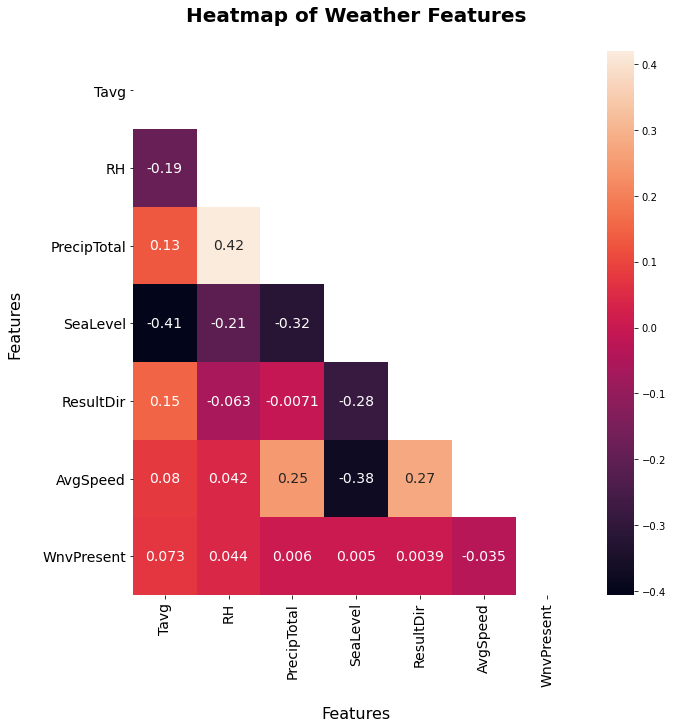

In [7]:
#create heatmap for the weather features

#create plot
plt.figure(figsize=(10,10))

#create correlation matrix 
wnv_weather = trap_weather[[
    'Tavg', 'RH', 'PrecipTotal',
    'SeaLevel', 'ResultDir', 'AvgSpeed',
    'WnvPresent'
]]
corrMatrix = wnv_weather.corr()

#create triangle mask
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

#plot heatmap
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size":14}, mask = mask)

#set title and x,y labels
plt.title("Heatmap of Weather Features", pad=30, weight='bold', size=20)

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14, rotation = 90)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set labels
plt.xlabel('Features', labelpad=20, size=16)
plt.ylabel('Features', labelpad=20, size=16)

plt.savefig('../plots/heatmap-weather.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: After dropping most of the features that display strong correlation with each other, we have a set of weather features that show low correlation with each other, hence we can assume that multicollinearity is reduced. 

#### Drop Columns from Trap-Weather Dataset

In [8]:
# view columns in dataset
trap_weather.columns

Index(['Date', 'Day', 'Month', 'Year', 'Species', 'Trap', 'Latitude',
       'Longitude', 'Station', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin',
       'Tavg', 'RH', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

- 'Date' column will be dropped as we have separated the column values into 'Day', 'Month' & 'Year'
- 'Station' will be dropped as the inidividual weather measurements from each weather station have been merged with the respective coordinates
- 'NumMosquitos' will be dropped as the column is absent from the kaggle test dataset, hence it will not be relevant for model training
- 'Trap' column will be dropped as the test data contains some traps that are not in the train data.
- 'Year' column will be dropped as the train data contains odd year entries while the test data contains even year entries.

In [9]:
# drop 'Date', 'Station', 'Trap', 'Year' & 'NumMosquitos' columns
trap_weather.drop(columns=[
    'Date', 'Station', 'NumMosquitos',
    'Trap', 'Year'
],inplace=True)

- Based on our EDA on the weather features, the columns 'Tmax', 'Tmin','DewPoint', 'WetBulb', 'Heat', 'Cool' and 'ResultSpeed' will be removed to reduce multicollinearity.

In [10]:
# drop 'Tmax', 'Tmin', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'ResultSpeed' columns
trap_weather.drop(columns=[
    'Tmax', 'Tmin','DewPoint', 
    'WetBulb', 'Heat', 'Cool',
    'ResultSpeed'
],inplace=True)

#### Group Latitude and Longitude Coordinates

The latitude and longtitude coordinates will be grouped using units of 0.1 and dummified. This will give us a better representation of the areas that have a higher presence of WNV. 

In [11]:
# group latitude and longitude coordinates 

conditions = [
    # latitude <= 41.7
    (trap_weather['Latitude'] <= 41.7) & (trap_weather['Longitude'] <= -87.9),
    (trap_weather['Latitude'] <= 41.7) & (trap_weather['Longitude'] <= -87.8),
    (trap_weather['Latitude'] <= 41.7) & (trap_weather['Longitude'] <= -87.7),
    (trap_weather['Latitude'] <= 41.7) & (trap_weather['Longitude'] <= -87.6),
    (trap_weather['Latitude'] <= 41.7) & (trap_weather['Longitude'] <= -87.5),
    # latitude <= 41.8
    (trap_weather['Latitude'] <= 41.8) & (trap_weather['Longitude'] <= -87.9),
    (trap_weather['Latitude'] <= 41.8) & (trap_weather['Longitude'] <= -87.8),
    (trap_weather['Latitude'] <= 41.8) & (trap_weather['Longitude'] <= -87.7),
    (trap_weather['Latitude'] <= 41.8) & (trap_weather['Longitude'] <= -87.6),
    (trap_weather['Latitude'] <= 41.8) & (trap_weather['Longitude'] <= -87.5),
    # latitude <= 41.9
    (trap_weather['Latitude'] <= 41.9) & (trap_weather['Longitude'] <= -87.9),
    (trap_weather['Latitude'] <= 41.9) & (trap_weather['Longitude'] <= -87.8),
    (trap_weather['Latitude'] <= 41.9) & (trap_weather['Longitude'] <= -87.7),
    (trap_weather['Latitude'] <= 41.9) & (trap_weather['Longitude'] <= -87.6),
    (trap_weather['Latitude'] <= 41.9) & (trap_weather['Longitude'] <= -87.5),
     # latitude <= 42.0
    (trap_weather['Latitude'] <= 42.0) & (trap_weather['Longitude'] <= -87.9),
    (trap_weather['Latitude'] <= 42.0) & (trap_weather['Longitude'] <= -87.8),
    (trap_weather['Latitude'] <= 42.0) & (trap_weather['Longitude'] <= -87.7),
    (trap_weather['Latitude'] <= 42.0) & (trap_weather['Longitude'] <= -87.6),
    (trap_weather['Latitude'] <= 42.0) & (trap_weather['Longitude'] <= -87.5),
     # latitude <= 42.1
    (trap_weather['Latitude'] <= 42.1) & (trap_weather['Longitude'] <= -87.9),
    (trap_weather['Latitude'] <= 42.1) & (trap_weather['Longitude'] <= -87.8),
    (trap_weather['Latitude'] <= 42.1) & (trap_weather['Longitude'] <= -87.7),
    (trap_weather['Latitude'] <= 42.1) & (trap_weather['Longitude'] <= -87.6),
    (trap_weather['Latitude'] <= 42.1) & (trap_weather['Longitude'] <= -87.5),
]

groups = [i for i in range(1,26)]

trap_weather['Coordinate_Group'] = np.select(conditions, groups, default = 0)

In [12]:
# drop 'Latitude' and 'Longitude' columns since we have grouped the coordinates
trap_weather.drop(columns=[
    'Latitude', 'Longitude'
],inplace=True)

In [13]:
# view first 5 rows in dataset
trap_weather.head()

,Day,Month,Species,WnvPresent,Tavg,RH,PrecipTotal,SeaLevel,ResultDir,AvgSpeed,Coordinate_Group
0,29,5,CULEX PIPIENS,0,77.0,50.000000,0.0,30.09,16.0,7.4,9
1,29,5,CULEX PIPIENS/RESTUANS,0,74.0,55.555556,0.0,30.11,18.0,6.5,17
2,29,5,CULEX PIPIENS/RESTUANS,0,74.0,55.555556,0.0,30.11,18.0,6.5,17
3,29,5,CULEX PIPIENS/RESTUANS,0,77.0,50.000000,0.0,30.09,16.0,7.4,14
4,29,5,CULEX PIPIENS/RESTUANS,0,74.0,55.555556,0.0,30.11,18.0,6.5,19


#### Dummify 'Month', 'Species' and 'Coordinate_Group' columns

In addition to 'Species' and 'Coordinate_Group', we have dummified the 'Month' column to treat each month as an independent variable. 

In [14]:
# dummfiy 'Species' and 'Coordinate_Group' columns
trap_weather_dummied = pd.get_dummies(data=trap_weather, columns=['Month', 'Species', 'Coordinate_Group'])

In [15]:
# view columns after dummifying
trap_weather_dummied.columns

Index(['Day', 'WnvPresent', 'Tavg', 'RH', 'PrecipTotal', 'SeaLevel',
       'ResultDir', 'AvgSpeed', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS',
       'Coordinate_Group_3', 'Coordinate_Group_4', 'Coordinate_Group_5',
       'Coordinate_Group_8', 'Coordinate_Group_9', 'Coordinate_Group_10',
       'Coordinate_Group_13', 'Coordinate_Group_14', 'Coordinate_Group_16',
       'Coordinate_Group_17', 'Coordinate_Group_18', 'Coordinate_Group_19',
       'Coordinate_Group_22', 'Coordinate_Group_23', 'Coordinate_Group_24'],
      dtype='object')

In [16]:
# compare shape of dataset before and after dummifying
print('Shape Before Dummifying:', trap_weather.shape)
print('Shape After Dummifying:', trap_weather_dummied.shape)

Shape Before Dummifying: (8610, 11)
Shape After Dummifying: (8610, 36)


### Modelling of Trap-Weather Dataset

For modelling, we will use the following classification models:
- Logistic Regression 
- Support Vector Machine 
- K Nearest Neighbors 
- Random Forest 

#### Train-Test Split and Scale Trap-Weather Dataset

In [17]:
# set X and y datasets
X = trap_weather_dummied.drop(columns=['WnvPresent', 'Month_5'])
y = trap_weather_dummied['WnvPresent']

In [18]:
# train/test split 
# since there are 8610 rows, we can use 70/30 split
# we will stratify the split and assign random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.30, random_state=42)

In [19]:
# scale the dataset
# the data should be scaled as the scale of some features may affect the model training

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Define Functions for Accuracy and Recall Score

In [20]:
# define accuracy score function
def acc_scorer(model, X_train, X_test, y_train, y_test):
    acc_train = accuracy_score(y_true = y_train,
                        y_pred = model.predict(X_train))
    acc_test = accuracy_score(y_true = y_test,
                       y_pred = model.predict(X_test))
    acc_diff = acc_train - acc_test
    
    print("The training accuracy for " + str(model.__class__.__name__) + " is: " + '{0:.3f}'.format(acc_train))
    print("The testing accuracy for " + str(model.__class__.__name__) + " is: " + '{0:.3f}'.format(acc_test))
    print("The difference in accuracy is " + '{0:.3f}'.format(acc_diff))
    print()

In [21]:
# define recall score function
def rec_scorer(model, X_train, X_test, y_train, y_test):
    rec_train = recall_score(y_true = y_train,
                        y_pred = model.predict(X_train))
    rec_test = recall_score(y_true = y_test,
                       y_pred = model.predict(X_test))
    rec_diff = rec_train - rec_test
    
    print("The training recall for " + str(model.__class__.__name__) + " is: " + '{0:.3f}'.format(rec_train))
    print("The testing recall for " + str(model.__class__.__name__) + " is: " + '{0:.3f}'.format(rec_test))
    print("The difference in recall is " + '{0:.3f}'.format(rec_diff))
    print()

### Logistic Regression

#### Instantiate and Fit the Model

In [22]:
# instantiate the model
lr = LogisticRegression(random_state=42)

# fit the model
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### Hyperparameter Tuning with GridSearchCV

In [23]:
# create hyperparameter options
params = {'solver': ['liblinear'], 'class_weight': ['balanced'], 'penalty':['l1','l2'], 'C':[0.1,1.0,10]}

# perform grid search using 5-fold cross validation
clf = GridSearchCV(lr, params, cv=5, verbose=0)

# fit and train model after hyperparameter tuning
best_lr = clf.fit(X_train, y_train)

# print optimized parameters 
print(clf.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


From hyperparameter tuning, the optimal hyperparameters for the Logistic Regression model are 'C' = 1.0, 'class_weight' = 'balanced', 'penalty' = 'l2' and 'solver' = 'liblinear'.  

In [24]:
# compare accuracy and recall scores for model before and after hyperparameter tuning

acc_scorer(lr, X_train, X_test, y_train, y_test)
rec_scorer(lr, X_train, X_test, y_train, y_test)

acc_scorer(best_lr, X_train, X_test, y_train, y_test)
rec_scorer(best_lr, X_train, X_test, y_train, y_test)

The training accuracy for LogisticRegression is: 0.947
The testing accuracy for LogisticRegression is: 0.947
The difference in accuracy is -0.000

The training recall for LogisticRegression is: 0.000
The testing recall for LogisticRegression is: 0.000
The difference in recall is 0.000

The training accuracy for GridSearchCV is: 0.640
The testing accuracy for GridSearchCV is: 0.657
The difference in accuracy is -0.017

The training recall for GridSearchCV is: 0.816
The testing recall for GridSearchCV is: 0.818
The difference in recall is -0.002



**Deduction**: When comparing the initial logistic regression model to the optimized model, the train and test accuracy scores for the model after hyperparameter tuning decreases by 30.7% and 29.0% respectively but the recall score for train and test increases by 81.6% and 81.8% respectively. This is likely due to the class weight being set to 'balanced' which allows a more balanced sampling for the minority class which in this case is 'WnvPresent' = 1. This greatly increases the number of cases where WNV is correctly predicted as being present. This is crucial in controlling WNV as it gives a more accurate representation of which areas are susceptible to WNV. It would be better to over predict the areas that have WNV as we can take more preventive measures like spraying of pesticide to reduce the mosquito population and reduce the spread of WNV.

#### Model Evaluation

In [25]:
# predict the results
y_pred = best_lr.predict(X_test)

# generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2446
           1       0.12      0.82      0.20       137

    accuracy                           0.66      2583
   macro avg       0.55      0.73      0.49      2583
weighted avg       0.94      0.66      0.75      2583



In [26]:
# generate confusion matrix
cm = confusion_matrix(y_test,y_pred)

# calculate accuracy, precision, recall(sensitivity) and specificity
tn, fp, fn, tp = cm.ravel()

acc_score = accuracy_score(y_test, y_pred)        # true predictions / total predictions
prec_score = precision_score(y_test, y_pred)      # true positives / (true positives + false positives)
rec_score = recall_score(y_test, y_pred)          # true positives / (true positives + false negatives)
spec_score = tn / (tn+fp)                         # true negative rate

print("accuracy score : " + str(acc_score))
print("precision score : " + str(prec_score))
print("recall score : " + str(rec_score))
print("specificity score : " + str(spec_score))

accuracy score : 0.6569879984514131
precision score : 0.11510791366906475
recall score : 0.8175182481751825
specificity score : 0.6479967293540474


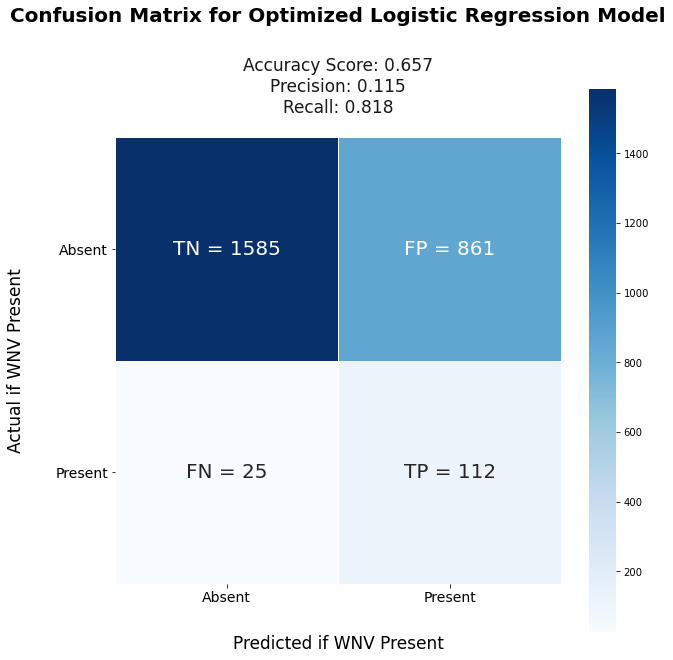

In [27]:
# create modified labels for confusion matrix
modified_cm = []

for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

# plot confusion matrix
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size":20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Absent','Present'],
            yticklabels = ['Absent','Present']);

# set x and y labels
plt.xlabel('Predicted if WNV Present', labelpad=30, fontsize = 17);
plt.ylabel('Actual if WNV Present', labelpad=30, fontsize = 17);

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set title and subtitle 
ax.text(x=0.5, y=1.25, s='Confusion Matrix for Optimized Logistic Regression Model', 
        fontsize=20, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.0, s='Accuracy Score: {:.3f}'.format(acc_score) + '\n' 
         + 'Precision: {:.3f}'.format(prec_score) + '\n'
         + 'Recall: {:.3f}'.format(rec_score) + '\n', 
        fontsize=17, alpha=0.9, ha='center', va='bottom', transform=ax.transAxes);

plt.savefig('../plots/cm-logistic-regression.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: The confusion matrix shows that the number of correctly predicted entries where WNV is present is 112 while 25 where wrongly classified as being absent of WNV. This corresponds to our recall score of 0.818 which implies that 81.8% of entries are correctly predicted to have presence of WNV. The accuracy of the model is less important to our model performance as it is heavily influenced by the imbalanced dataset, given that 95% of entries in the dataset have 'WNVPresent' = 0.

#### ROC Plot and AUC Score

<Figure size 3000x3000 with 0 Axes>

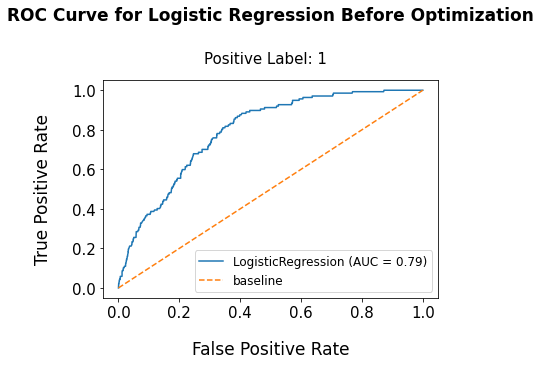

In [28]:
# plot roc curve for logistic regression before optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(lr, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for Logistic Regression Before Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-logistic-regression.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

<Figure size 3000x3000 with 0 Axes>

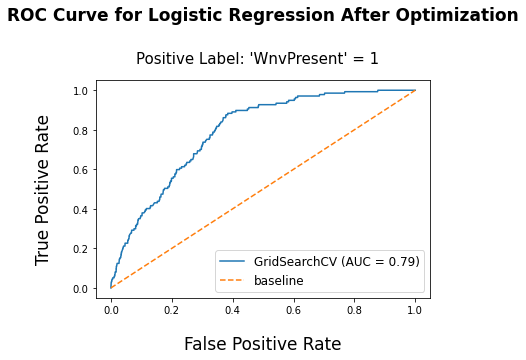

In [29]:
# plot roc curve for logistic regression after optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(best_lr, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for Logistic Regression After Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 'WnvPresent' = 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

plt.savefig('../plots/ROC-logistic-regression-optim.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: The AUC for the ROC curve before and after optimization are the same, at 0.79. This is better than the baseline AUC of 0.50. There is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more number of True positives and True negatives than False negatives and False positives.  

In [30]:
# plot log reg coefficient table
odds = np.exp(lr.coef_[0])
coef_table = pd.DataFrame(odds, 
             X.columns, 
             columns=['odds_coef'])\
            .sort_values(by='odds_coef', ascending=False)

**Note**: Because of the logit function, logistic regression coefficients represent the log odds that an observation is in the target class = 1 given the values of its X variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them. 

In [31]:
coef_table.head(20)

,odds_coef
Month_8,2.892771
Month_9,2.010299
Tavg,1.484479
Coordinate_Group_17,1.396158
Species_CULEX PIPIENS,1.265604
Species_CULEX PIPIENS/RESTUANS,1.232219
Month_7,1.218872
Day,1.197524
SeaLevel,1.174961
ResultDir,1.141850


**Deduction**: From the logistic regression coefficients, the top 2 variables with the highest odds coefficient are Month_8 and Month_9 with odds coefficients of 2.893 and 2.010 respectively. The top 5 weather variables with the highest coefficients are 'Tavg', 'SeaLevel', 'ResultDir', 'RH' and 'PrecipTotal'. Their respective values are 1.484, 1.174, 1.141, 1.048 and 1.032. The two species of mosquitoes with the highest coefficients are Culex Pipiens, 1.266, and Culex Pipiens/Restuans, 1.232. As for areas with higher coefficients, the 5 coordinate groups with the highest coefficients are Group 17, Group 18, Group 23, Group 16 and Group 4.

| Group | Latitude | Longitude | 
|:---:|:---:|:---:|
|17| 41.9 to 42.0| -87.9 to -87.8 |
|18|41.9 to 42.0| -87.8 to -87.7| 
|23|42.0 to 42.1 | -87.8 to -87.7 |
|16|41.9 to 42.0| -88.0 to -87.9|
|4| 41.6 to 41.7| -87.7 to -87.6| 

### Support Vector Machine

#### Instantiate and Fit the Model

In [32]:
# instantiate the model
svm = SVC(class_weight='balanced', probability=True, random_state=42)

# fit the model
svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

#### Hyperparameter Tuning with GridSearchCV

In [33]:
# Create hyperparameter options
params = {'C':[0.1,1.0,10]}

# Create grid search using 5-fold cross validation
clf = GridSearchCV(svm, params, cv=5)

# Fit grid search
best_svm = clf.fit(X_train, y_train)

print(clf.best_estimator_.get_params())

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


**Deduction**: From hyperparameter tuning, the optimal hyperparameters for SVM model are 'C' = 10, 'class_weight' = 'balanced' and 'probability' = True. The 'class_weight' = 'balanced' parameter helps to adjust the sampling weights of 'WnvPresent' to compensate for the imbalance in the dataset. This allows more optimal training and fitting of the classification model to predict the minority class.

In [34]:
# display scores for svm models before and after optimization
acc_scorer(svm, X_train, X_test, y_train, y_test)
rec_scorer(svm, X_train, X_test, y_train, y_test)

acc_scorer(best_svm, X_train, X_test, y_train, y_test)
rec_scorer(best_svm, X_train, X_test, y_train, y_test)

The training accuracy for SVC is: 0.749
The testing accuracy for SVC is: 0.729
The difference in accuracy is 0.020

The training recall for SVC is: 0.931
The testing recall for SVC is: 0.752
The difference in recall is 0.179

The training accuracy for GridSearchCV is: 0.831
The testing accuracy for GridSearchCV is: 0.781
The difference in accuracy is 0.050

The training recall for GridSearchCV is: 0.991
The testing recall for GridSearchCV is: 0.562
The difference in recall is 0.429



**Deduction**: When comparing the initial SVM model to the optimized model, the train and test accuracy scores for the model after hyperparameter tuning increases by 8.2% and 5.2% respectively. As for the recall scores for train and test, the train score increases by 6% to 99.1%, but the test recall score decreases by 19.0% to 56.2%. This suggests there is overfitting of the train model resulting in a significant difference between the train and test recall scores. The SVM model allows the class weight to be set to 'balanced', this facilitates a more balanced sampling for the minority class which in this case is 'WnvPresent' = 1. 

#### Model Evaluation

In [35]:
# predict the results
y_pred = best_svm.predict(X_test)

# generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2446
           1       0.13      0.56      0.21       137

    accuracy                           0.78      2583
   macro avg       0.55      0.68      0.54      2583
weighted avg       0.93      0.78      0.84      2583



In [36]:
# generate confusion matrix
cm = confusion_matrix(y_test,y_pred)

# calculate accuracy, precision, recall(sensitivity) and specificity
tn, fp, fn, tp = cm.ravel()

acc_score = accuracy_score(y_test, y_pred)        # true predictions / total predictions
prec_score = precision_score(y_test, y_pred)      # true positives / (true positives + false positives)
rec_score = recall_score(y_test, y_pred)          # true positives / (true positives + false negatives)
spec_score = tn / (tn+fp)                         # true negative rate

print("accuracy score : " + str(acc_score))
print("precision score : " + str(prec_score))
print("recall score : " + str(rec_score))
print("specificity score : " + str(spec_score))

accuracy score : 0.7808749516066589
precision score : 0.1320754716981132
recall score : 0.5620437956204379
specificity score : 0.7931316434995912


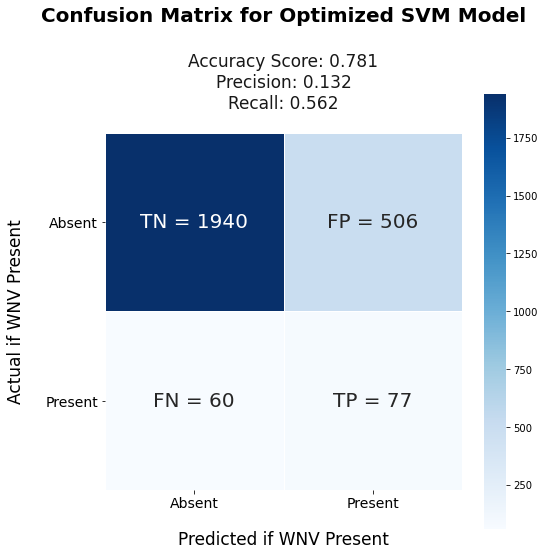

In [37]:
# create modified labels for confusion matrix
modified_cm = []

for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

# plot confusion matrix
plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size":20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Absent','Present'],
            yticklabels = ['Absent','Present']);

# set x and y labels
plt.xlabel('Predicted if WNV Present', labelpad=20, fontsize = 17);
plt.ylabel('Actual if WNV Present', labelpad=20, fontsize = 17);

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set title and subtitle 
ax.text(x=0.5, y=1.3, s='Confusion Matrix for Optimized SVM Model', 
        fontsize=20, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.0, s='Accuracy Score: {:.3f}'.format(acc_score) + '\n' 
         + 'Precision: {:.3f}'.format(prec_score) + '\n'
         + 'Recall: {:.3f}'.format(rec_score) + '\n', 
        fontsize=17, alpha=0.9, ha='center', va='bottom', transform=ax.transAxes);

plt.savefig('../plots/cm-SVM.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: From the confusion matrix, we can observe that the model correctly classified 77 entries with presence of WNV but wrongly classified 60 entries as be absent of WNV. This corresponds to a recall score of 0.562 which implies that 56.2% of all WNV cases were correctly predicted.

#### ROC Plot and AUC Score

<Figure size 3000x3000 with 0 Axes>

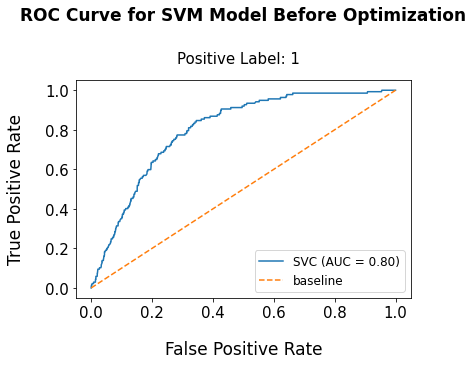

In [38]:
# plot roc curve for SVM model before optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(svm, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for SVM Model Before Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-SVM.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

<Figure size 3000x3000 with 0 Axes>

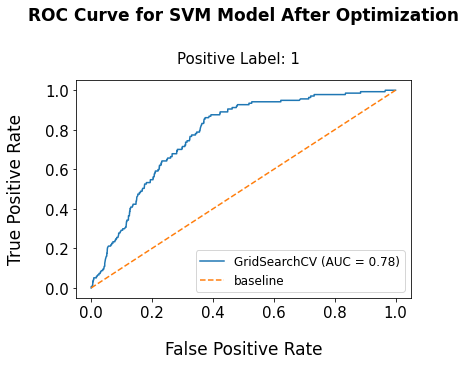

In [39]:
# plot roc curve for SVM model after optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(best_svm, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for SVM Model After Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-SVM-optim.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: The AUC for the ROC curve before and after optimization are 0.80 and 0.78 respectively. Although the AUC decreases by 0.02 after optimizing the hyperparamters, the model performance after optimization is still better than the baseline AUC of 0.50. There is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.  

### K Nearest Neighbors

#### Instantiate and Fit the Model

In [40]:
# instantiate the model
knn = KNeighborsClassifier()

# fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

#### Hyperparameter Tuning with GridSearchCV

In [41]:
# Create hyperparameter options
params = {"n_neighbors":[3,5,7,9,11,13,15]}

# Create grid search using 5-fold cross validation
clf = GridSearchCV(knn, params, cv=5)

# Fit grid search
best_knn = clf.fit(X_train, y_train)

print(clf.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}


**Deduction**: The optimal hyperparameters for KNN is 'n_neighbors' = 13.

In [42]:
# compare accuracy and recall scores for model before and after hyperparameter tuning

acc_scorer(knn, X_train, X_test, y_train, y_test)
rec_scorer(knn, X_train, X_test, y_train, y_test)

acc_scorer(best_knn, X_train, X_test, y_train, y_test)
rec_scorer(best_knn, X_train, X_test, y_train, y_test)

The training accuracy for KNeighborsClassifier is: 0.946
The testing accuracy for KNeighborsClassifier is: 0.939
The difference in accuracy is 0.007

The training recall for KNeighborsClassifier is: 0.122
The testing recall for KNeighborsClassifier is: 0.022
The difference in recall is 0.100

The training accuracy for GridSearchCV is: 0.947
The testing accuracy for GridSearchCV is: 0.947
The difference in accuracy is 0.001

The training recall for GridSearchCV is: 0.009
The testing recall for GridSearchCV is: 0.000
The difference in recall is 0.009



**Deduction**: When comparing the initial KNN model to the optimized model, the train and test accuracy scores for the model after hyperparameter tuning remain high at around 94%. As for the recall scores, the train recall score drops from 12.2% to 0.9% while the test recall score remains also dropped from 2.2% to 0.0%. This implies the KNN model has very poor performance in classifying the positive class because of the imbalance in the dataset. 

#### Model Evaluation

In [43]:
# predict the results
y_pred = best_knn.predict(X_test)

# generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2446
           1       0.00      0.00      0.00       137

    accuracy                           0.95      2583
   macro avg       0.47      0.50      0.49      2583
weighted avg       0.90      0.95      0.92      2583



In [44]:
# generate confusion matrix
cm = confusion_matrix(y_test,y_pred)

# calculate accuracy, precision, recall(sensitivity) and specificity
tn, fp, fn, tp = cm.ravel()

acc_score = accuracy_score(y_test, y_pred)        # true predictions / total predictions
prec_score = precision_score(y_test, y_pred)      # true positives / (true positives + false positives)
rec_score = recall_score(y_test, y_pred)          # true positives / (true positives + false negatives)
spec_score = tn / (tn+fp)                         # true negative rate

print("accuracy score : " + str(acc_score))
print("precision score : " + str(prec_score))
print("recall score : " + str(rec_score))
print("specificity score : " + str(spec_score))

accuracy score : 0.9465737514518002
precision score : 0.0
recall score : 0.0
specificity score : 0.9995911692559281


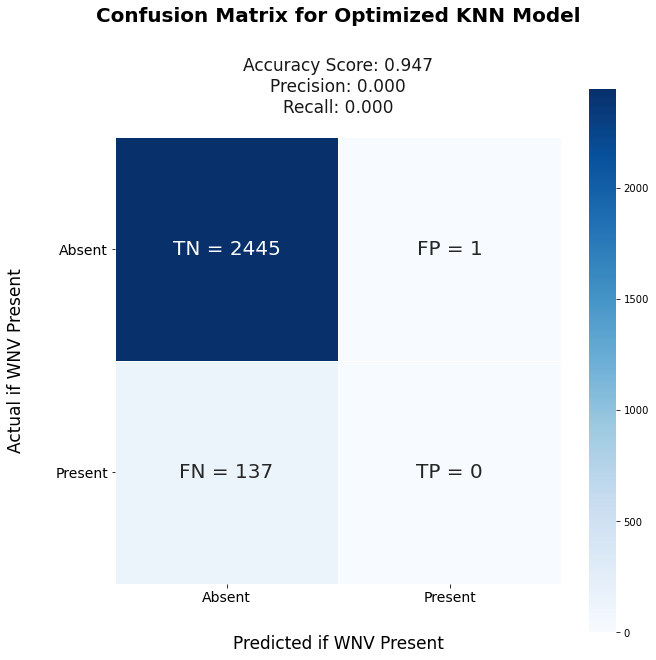

In [45]:
# create modified labels for confusion matrix
modified_cm = []

for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

# plot confusion matrix
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size":20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Absent','Present'],
            yticklabels = ['Absent','Present']);

# set x and y labels
plt.xlabel('Predicted if WNV Present', labelpad=30, fontsize = 17);
plt.ylabel('Actual if WNV Present', labelpad=30, fontsize = 17);

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set title and subtitle 
ax.text(x=0.5, y=1.25, s='Confusion Matrix for Optimized KNN Model', 
        fontsize=20, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.0, s='Accuracy Score: {:.3f}'.format(acc_score) + '\n' 
         + 'Precision: {:.3f}'.format(prec_score) + '\n'
         + 'Recall: {:.3f}'.format(rec_score) + '\n', 
        fontsize=17, alpha=0.9, ha='center', va='bottom', transform=ax.transAxes);

plt.savefig('../plots/cm-KNN.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: From the confusion matrix, the optimized KNN model did not classify any positive entries correctly. This corresponds to the recall score of 0, which is not ideal. 

#### ROC Plot and AUC Score

<Figure size 3000x3000 with 0 Axes>

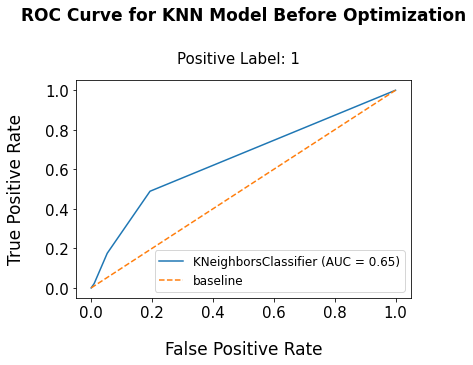

In [46]:
# plot roc curve for knn before optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(knn, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for KNN Model Before Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-KNN.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

<Figure size 3000x3000 with 0 Axes>

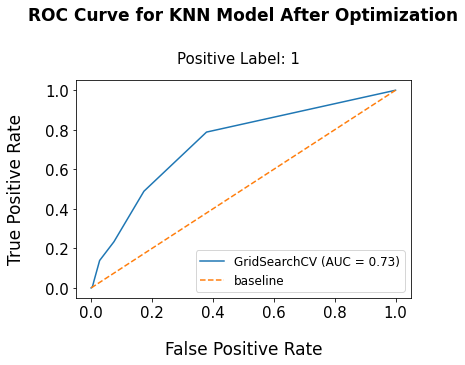

In [47]:
# plot roc curve for knn after optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(best_knn, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for KNN Model After Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-KNN-optim.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: The AUC for the KNN model before and after optimization is 0.65 and 0.73 respectively. Both models perform above the baseline of 0.50, however from the recall score, we can deduce that the model performs poorly in classifying positive cases.

### Random Forest Classifier

#### Instantiate and Fit the Model

In [48]:
# instantiate the model
rf = RandomForestClassifier(random_state=42)

# fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Hyperparameter Tuning with GridSearchCV

In [49]:
# create hyperparameter options
params = {'class_weight': ['balanced'], 'n_estimators': [10,20,30,40,50,100]}

# create grid search using 5-fold cross validation
clf = GridSearchCV(rf, params, cv=5)

# fit grid search
best_rf = clf.fit(X_train, y_train)

print(clf.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


**Deduction**: The optimal hyperparameters for Random Forest is 'class_weight' = 'balanced' and 'n_estimators' = '10'.

In [50]:
# view accuracy and recall scores
acc_scorer(rf, X_train, X_test, y_train, y_test)
rec_scorer(rf, X_train, X_test, y_train, y_test)

acc_scorer(best_rf, X_train, X_test, y_train, y_test)
rec_scorer(best_rf, X_train, X_test, y_train, y_test)

The training accuracy for RandomForestClassifier is: 0.953
The testing accuracy for RandomForestClassifier is: 0.936
The difference in accuracy is 0.017

The training recall for RandomForestClassifier is: 0.197
The testing recall for RandomForestClassifier is: 0.029
The difference in recall is 0.168

The training accuracy for GridSearchCV is: 0.901
The testing accuracy for GridSearchCV is: 0.863
The difference in accuracy is 0.037

The training recall for GridSearchCV is: 0.772
The testing recall for GridSearchCV is: 0.307
The difference in recall is 0.465



**Deduction**: When comparing the initial Random Forest Model to the optimized model, the train and test accuracy scores for the model after hyperparameter tuning remain high at 90.1% and 86.3%. As for the recall scores, the train recall score increases from 19.7% to 77.2% and the test recall score increases from 2.9% to 30.7%. This implies that the optimized Random Forest model shows decent performance in classifying the positive class in an imbalanced dataset. However, the optimized model displays significant overfitting as the difference between the train and test recall score is 46.5%. 

#### Model Evaluation

In [51]:
# predict the results
y_pred = best_rf.predict(X_test)

# generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      2446
           1       0.14      0.31      0.19       137

    accuracy                           0.86      2583
   macro avg       0.55      0.60      0.56      2583
weighted avg       0.91      0.86      0.89      2583



In [52]:
# generate confusion matrix
cm = confusion_matrix(y_test,y_pred)

# calculate accuracy, precision, recall(sensitivity) and specificity
tn, fp, fn, tp = cm.ravel()

acc_score = accuracy_score(y_test, y_pred)        # true predictions / total predictions
prec_score = precision_score(y_test, y_pred)      # true positives / (true positives + false positives)
rec_score = recall_score(y_test, y_pred)          # true positives / (true positives + false negatives)
spec_score = tn / (tn+fp)                         # true negative rate

print("accuracy score : " + str(acc_score))
print("precision score : " + str(prec_score))
print("recall score : " + str(rec_score))
print("specificity score : " + str(spec_score))

accuracy score : 0.8633372048006195
precision score : 0.14
recall score : 0.30656934306569344
specificity score : 0.8945216680294358


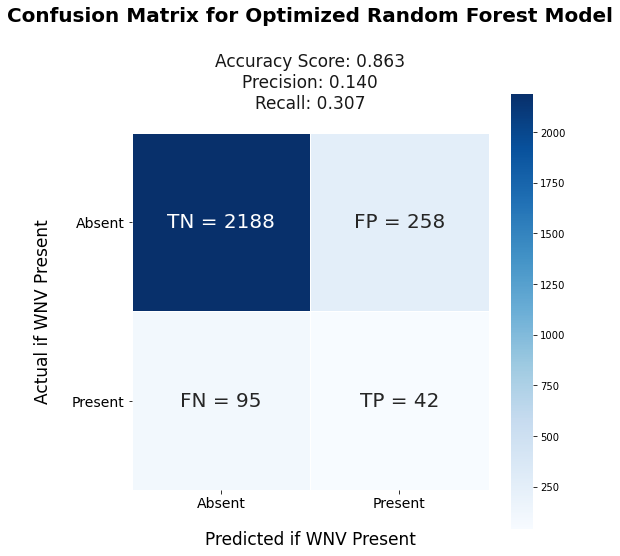

In [53]:
# create modified labels for confusion matrix
modified_cm = []

for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

# plot confusion matrix
plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size":20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Absent','Present'],
            yticklabels = ['Absent','Present']);

# set x and y labels
plt.xlabel('Predicted if WNV Present', labelpad=20, fontsize = 17);
plt.ylabel('Actual if WNV Present', labelpad=20, fontsize = 17);

#set tick labels
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14, rotation = 0)

#set title and subtitle 
ax.text(x=0.5, y=1.3, s='Confusion Matrix for Optimized Random Forest Model', 
        fontsize=20, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.0, s='Accuracy Score: {:.3f}'.format(acc_score) + '\n' 
         + 'Precision: {:.3f}'.format(prec_score) + '\n'
         + 'Recall: {:.3f}'.format(rec_score) + '\n', 
        fontsize=17, alpha=0.9, ha='center', va='bottom', transform=ax.transAxes);

plt.savefig('../plots/cm-random-forest.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: From the confusion matrix, we can observe that the model correctly classified 42 entries with presence of WNV but wrongly classified 95 entries to be absent of WNV. This corresponds to a recall score of 0.307 which implies that 30.7% of all positive entries are correctly classified. 

#### ROC Plot and AUC Score

<Figure size 3000x3000 with 0 Axes>

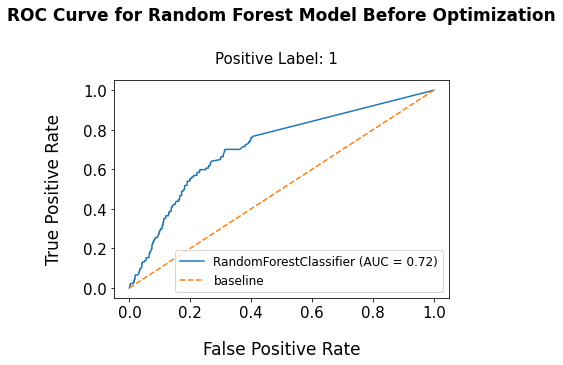

In [54]:
# plot roc curve for random forest model before optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(rf, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for Random Forest Model Before Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-random-forest.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

<Figure size 3000x3000 with 0 Axes>

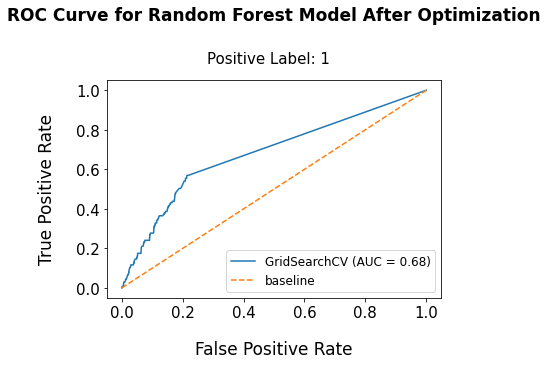

In [55]:
# plot roc curve for random forest model after optimization
plt.figure(figsize=(10,10), dpi=300)

ax = plot_roc_curve(best_rf, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline', linestyle='--')
plt.legend(fontsize=12)

# set title, suptitle and x and y labels
plt.title("ROC Curve for Random Forest Model After Optimization", pad=60, weight='bold', fontsize = 17) 
plt.suptitle("Positive Label: 1", fontsize=15)
plt.xlabel('False Positive Rate', labelpad=20, fontsize = 17)
plt.ylabel('True Positive Rate', labelpad=20, fontsize = 17);

#set tick labels
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('../plots/ROC-random-forest-optim.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

**Deduction**: The AUC for the Random Forest model before and after optimization is 0.72 and 0.68 respectively. Both models perform above the baseline of 0.50, however from the recall score, the model shows average performance in classifying positive cases.

## Results & Analysis

Summarizing the `Accuracy Score`, `Recall Score` and `AUC Score` in the table below for easy comparison:

| Optimized Model          |Training Accuracy | Testing Accuracy | Training Recall Score | Testing Recall Score |AUC Score |
|:-----------------------:|:----------------:|:----------------:|:------------:|:---------:|:---------:|
| Logistic Regression     |      0.640       |      0.657       |    0.816     |   0.818 |     0.79    |
| Support Vector Machine  |      0.831       |      0.781       |    0.991     | 0.562  |     0.78    | 
| K-Nearest Neighbors     |      0.947       |      0.947       |    0.009     | 0.000  |     0.73    |
| Random Forest Classifier|      0.901       |      0.863       |    0.772     | 0.307  |     0.68    |

Having evaluated 4 different classification models, the optimized Logistic Regression Classifier is the best performing model.

The confusion matrix for the optimized logistic regression model shows that the number of correctly predicted entries where WNV is present is 112 while 25 where wrongly classified as being absent of WNV. This corresponds to our recall score of 0.818 which implies that 81.8% of entries are correctly predicted to have presence of WNV. The accuracy of the model is less important to our model performance as it is heavily influenced by the imbalanced dataset, given that 95% of entries in the dataset have 'WNVPresent' = 0. 

The AUC for the ROC curve before and after optimization are both 0.79, which is better than the baseline AUC of 0.50. There is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.  

From the logistic regression coefficients, the top 2 variables with the highest odds coefficient are Month_8 (August) and Month_9 (September) with odds coefficients of 2.893 and 2.010 respectively. The top 5 weather variables with the highest coefficients are 'Tavg', 'SeaLevel', 'ResultDir', 'RH' and 'PrecipTotal'. Their respective values are 1.484, 1.174, 1.141, 1.048 and 1.032. The two species of mosquitoes with the highest coefficients are Culex Pipiens, 1.266, and Culex Pipiens/Restuans, 1.232. As for areas with higher coefficients, the 5 coordinate groups with the highest coefficients are Group 17, Group 18, Group 23, Group 16 and Group 4.


| Group | Latitude | Longitude |
|:---:|:---:|:---:|
|17| 41.9 to 42.0| -87.9 to -87.8 |
|18|41.9 to 42.0| -87.8 to -87.7| 
|23|42.0 to 42.1 | -87.8 to -87.7 |
|16|41.9 to 42.0| -88.0 to -87.9|
|4| 41.6 to 41.7| -87.7 to -87.6| 

The second best performing model is the optimized SVM model. From the confusion matrix, we can observe that the model correctly classified 77 entries with presence of WNV but wrongly classified 60 entries as be absent of WNV. This corresponds to a recall score of 0.562 which implies that 56.2% of all positive entries are correctly classified. 

The AUC for the ROC curve before and after optimization are 0.80 and 0.78 respectively. Although the AUC decreases by 0.02 after optimizing the hyperparamters, the model performance after optimization is still better than the baseline AUC of 0.50. There is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.  

Comparing the two models, the optimized logistic regression model will be used to predict the presence of WNV. This is because it has a higher recall score of 0.818 compared to 0.562. The AUC score of 0.79 is also higher than the optimized SVM model of 0.78.

## Kaggle Prediction

#### Import Kaggle-Weather Dataset

In [56]:
kaggle_weather = pd.read_csv('../data/test_weather_clean.csv')

In [57]:
kaggle_weather.head()

,Id,Date,Day,Month,Year,Species,Trap,Latitude,Longitude,Station,...,RH,DewPoint,WetBulb,Heat,Cool,PrecipTotal,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2008-06-11,11,6,2008,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1,...,50.0,56.0,64.0,0.0,9.0,0.0,29.99,8.9,18.0,10.0
1,2,2008-06-11,11,6,2008,CULEX RESTUANS,T002,41.95469,-87.800991,1,...,50.0,56.0,64.0,0.0,9.0,0.0,29.99,8.9,18.0,10.0
2,3,2008-06-11,11,6,2008,CULEX PIPIENS,T002,41.95469,-87.800991,1,...,50.0,56.0,64.0,0.0,9.0,0.0,29.99,8.9,18.0,10.0
3,4,2008-06-11,11,6,2008,CULEX SALINARIUS,T002,41.95469,-87.800991,1,...,50.0,56.0,64.0,0.0,9.0,0.0,29.99,8.9,18.0,10.0
4,5,2008-06-11,11,6,2008,CULEX TERRITANS,T002,41.95469,-87.800991,1,...,50.0,56.0,64.0,0.0,9.0,0.0,29.99,8.9,18.0,10.0


In [58]:
# drop 'Date', 'Station', 'Trap' & 'Year' columns
kaggle_weather.drop(columns=[
    'Date', 'Station',
    'Trap', 'Year'
],inplace=True)

In [59]:
# drop 'Tmax', 'Tmin', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'ResultSpeed' columns
kaggle_weather.drop(columns=[
    'Tmax', 'Tmin','DewPoint', 
    'WetBulb', 'Heat', 'Cool',
    'ResultSpeed'
],inplace=True)

In [60]:
print(kaggle_weather['Latitude'].min(), kaggle_weather['Latitude'].max())
print(kaggle_weather['Longitude'].min(), kaggle_weather['Longitude'].max())

41.644612 42.01743
-87.930995 -87.531635


In [61]:
# group latitude and longitude coordinates 

conditions = [
    # latitude <= 41.7
    (kaggle_weather['Latitude'] <= 41.7) & (kaggle_weather['Longitude'] <= -87.9),
    (kaggle_weather['Latitude'] <= 41.7) & (kaggle_weather['Longitude'] <= -87.8),
    (kaggle_weather['Latitude'] <= 41.7) & (kaggle_weather['Longitude'] <= -87.7),
    (kaggle_weather['Latitude'] <= 41.7) & (kaggle_weather['Longitude'] <= -87.6),
    (kaggle_weather['Latitude'] <= 41.7) & (kaggle_weather['Longitude'] <= -87.5),
    # latitude <= 41.8
    (kaggle_weather['Latitude'] <= 41.8) & (kaggle_weather['Longitude'] <= -87.9),
    (kaggle_weather['Latitude'] <= 41.8) & (kaggle_weather['Longitude'] <= -87.8),
    (kaggle_weather['Latitude'] <= 41.8) & (kaggle_weather['Longitude'] <= -87.7),
    (kaggle_weather['Latitude'] <= 41.8) & (kaggle_weather['Longitude'] <= -87.6),
    (kaggle_weather['Latitude'] <= 41.8) & (kaggle_weather['Longitude'] <= -87.5),
    # latitude <= 41.9
    (kaggle_weather['Latitude'] <= 41.9) & (kaggle_weather['Longitude'] <= -87.9),
    (kaggle_weather['Latitude'] <= 41.9) & (kaggle_weather['Longitude'] <= -87.8),
    (kaggle_weather['Latitude'] <= 41.9) & (kaggle_weather['Longitude'] <= -87.7),
    (kaggle_weather['Latitude'] <= 41.9) & (kaggle_weather['Longitude'] <= -87.6),
    (kaggle_weather['Latitude'] <= 41.9) & (kaggle_weather['Longitude'] <= -87.5),
     # latitude <= 42.0
    (kaggle_weather['Latitude'] <= 42.0) & (kaggle_weather['Longitude'] <= -87.9),
    (kaggle_weather['Latitude'] <= 42.0) & (kaggle_weather['Longitude'] <= -87.8),
    (kaggle_weather['Latitude'] <= 42.0) & (kaggle_weather['Longitude'] <= -87.7),
    (kaggle_weather['Latitude'] <= 42.0) & (kaggle_weather['Longitude'] <= -87.6),
    (kaggle_weather['Latitude'] <= 42.0) & (kaggle_weather['Longitude'] <= -87.5),
     # latitude <= 42.1
    (kaggle_weather['Latitude'] <= 42.1) & (kaggle_weather['Longitude'] <= -87.9),
    (kaggle_weather['Latitude'] <= 42.1) & (kaggle_weather['Longitude'] <= -87.8),
    (kaggle_weather['Latitude'] <= 42.1) & (kaggle_weather['Longitude'] <= -87.7),
    (kaggle_weather['Latitude'] <= 42.1) & (kaggle_weather['Longitude'] <= -87.6),
    (kaggle_weather['Latitude'] <= 42.1) & (kaggle_weather['Longitude'] <= -87.5),
]

groups = [i for i in range(1,26)]

kaggle_weather['Coordinate_Group'] = np.select(conditions, groups, default = 0)

In [62]:
# drop 'Latitude' and 'Longitude' columns since we have grouped the coordinates
kaggle_weather.drop(columns=[
    'Latitude', 'Longitude'
],inplace=True)

In [63]:
# dummfiy 'Species' and 'Coordinate_Group' columns
kaggle_weather_dummied = pd.get_dummies(data=kaggle_weather, columns=['Month', 'Species', 'Coordinate_Group'])

In [64]:
# view shape of kaggle_weather_dummied
kaggle_weather_dummied.shape

(116293, 36)

In [65]:
# view shape of X dataset
X.shape

(8610, 34)

In [66]:
#find columns that are in kaggle_weather_dummied but missing in X
list(set(kaggle_weather_dummied) - set(X))

['Id', 'Species_UNSPECIFIED CULEX']

In [67]:
# drop 'Species_UNSPECIFIED CULEX' & 'Id' columns and rename dataframe as test_df
test_df = kaggle_weather_dummied.drop(columns=['Species_UNSPECIFIED CULEX', 'Id'])

In [68]:
#find columns that are in test_df but missing in X
list(set(test_df) - set(X))

[]

In [69]:
test_df.shape

(116293, 34)

In [70]:
#scale test_df
test_df = scaler.transform(test_df)

In [71]:
# predict 'WnvPresent' from test_df
test_pred = best_lr.predict(test_df)

In [72]:
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
# add predicted 'WnvPresent' to kaggle_weather_dummied as 'WnvPresent' column
kaggle_weather_dummied['WnvPresent']=test_pred

In [74]:
# create new df with 'Id' and 'SalePrice' columns
pred_df = kaggle_weather_dummied[['Id', 'WnvPresent']]

In [75]:
# view first 5 rows of pred_df
pred_df

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
116288,116289,0
116289,116290,0
116290,116291,0
116291,116292,0


In [76]:
pred_df['WnvPresent'].value_counts()

0    99248
1    17045
Name: WnvPresent, dtype: int64

In [77]:
#save pred df to csv without the index
pred_df.to_csv('../data/test_pred.csv', index=False)

![competition score](../media/kaggle.png)